In [829]:
import pandas as pd
import plotly.express as px
import re
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.options.display.max_colwidth = 1000

In [830]:
# Functions
def clean_column_name(table):
    table.columns = table.columns.str.lower()
    table.columns = [re.sub('(,)|(:)|(-)', '', x) for x in table.columns]
    table.columns = [re.sub('(_)', ' ', x) for x in table.columns]
    table.columns = [x.strip(' ') for x in table.columns]
    # patient id column name normalization
    if "subject number" in table.columns: 
        table.rename(mapper={'subject number': 'patient id'}, axis=1, inplace=True)
    elif 'patient id' in table.columns: 
        table.rename(mapper={'patient id': 'patient id'}, axis=1, inplace=True)


def clean_str_column(table):
    for col in table.columns:
        if table[col].dtype == object:
            table[col] = table[col].str.lower()
            table[col] = table[col].str.replace('(,)|(:)|(-)', '', regex=True)
            table[col] = table[col].str.replace('(_)', ' ', regex=True)
            table[col] = table[col].str.strip(' ')

            
def get_plot_na(table, axis):
    na_count = table.isna().sum(axis=axis).sort_values(ascending=False)
    if axis==0:
        labels={'index': 'features', 'value':'missing value count'}
        fig = px.bar(na_count, height=600, width=2000, labels=labels)

    else:
        labels={'index': 'number of missing value', 'value':'number of patients'}
        fig = px.bar(na_count.value_counts().sort_index(), height=600, width=2000, labels=labels)

    fig.update_layout(font_size=8, bargap=0.3)
    return fig


def get_unique_value_col(table, string=False):
    '''
    table: pandas dataframe
    string: computes unique value only for columns containing string
    ''' 
    unique_value = []
    unique_value_str = set()
    for col in table.columns:
        unique_value.append(list(pd.unique(table[col])))
        if string and col != 'patient id':
            unique_value_str.update(set(pd.unique(table[col])))
    
    if string: 
        #even when the column dtype is str, some values are not string
        unique_value_str_clean = unique_value_str.copy()
        for el in unique_value_str:
            if not(isinstance(el, str)):
                unique_value_str_clean.remove(el)
        return(unique_value_str_clean)
    
    return pd.DataFrame({"unique_value": unique_value}, index=table.columns) 

def find_features(table, regex):
    r = re.compile(regex)
    
    #Search in name columns
    results_columns = (set(table.loc[:, table.columns.str.contains(r)].columns))
    
    #Search in values 
    str_columns = table.dtypes[df.dtypes == object].index #str columns
    results_value = table[str_columns].applymap(func=(lambda x: (r.search(x)) if pd.notnull(x) else x)).any()
    
    #combine results
    results_columns.update(results_value[results_value].index)
    
    return results_columns


# CONSTANTS
YES_REPLACEMENT = 'yes'
NO_REPLACEMENT = 'no'

# Loading

In [831]:
filepath = "../data/cerebral_elderly_stroke/subjects.csv"
filepath_desc = '../data/cerebral_perfusion_data/GE-75_data_dictionary.csv'
df = pd.read_csv(filepath)
df_desc = df_desc = pd.read_csv(filepath_desc, usecols=range(5))

There is no descriptive file for this dataset, but this dataset has been posted by the same team. I have seen similarities between the two datasets.

In [832]:
df.head()

,subject_number,completed_visit_status,htn_patient_medical_history,group,group2,age,height/m,mass/kg,bmi,gender,ethnicity,race,DM Non-DM STROKE,previous_tobacco_use,current_tobacco_use,pack_years,years,PREVIOUS ALCOHOL USE,ALCOHOL Dose/Week,Neuropathy AUTONOMIC SYMPTOMS,Dizziness AUTONOMIC SYMPTOMS,Numbness AUTONOMIC SYMPTOMS,Painful feet AUTONOMIC SYMPTOMS,Syncope AUTONOMIC SYMPTOMS,OH AUTONOMIC SYMPTOMS,"cancer,# FAMILY HISTORY",cancSpec FAMILY HISTORY,HeartDisease FAMILY HISTORY,Hdspecific FAMILY HISTORY,HTN FAMILY HISTORY,HTNspecific FAMILY HISTORY,DM FAMILY HISTORY,Dmspecific FAMILY HISTORY,StrokeFAMILY HISTORY,StrokeSpecific FAMILY HISTORY,HTN YRS PATIENT MEDICAL HISTORY,CANCER PATIENT MEDICAL HISTORY,STROKE PATIENT MEDICAL HISTORY,STROKE YR PATIENT MEDICAL HISTORY,ATRIAL FIBTRILLATION PATIENT MEDICAL HISTORY,HEART FAILURE =CHF /IFARCTION=-MI PATIENT MEDICAL HISTORY,HYPERLIPIDEMIA PATIENT MEDICAL HISTORY,DM PATIENT MEDICAL HISTORY,Stroke Date,NIHSS,MRS,Stroke Group,Stroke Side,Stroke Etiology,Symptoms,Lesions,Carotids,Tapered Medications taken during Visit 2,ANTIPLATELETS,ANTICOAGULANTS,ANTIHYPERLIPIDEMIC,ANTIPARKINSONIAN,STATINS,ESTROGEN,ACE INHIBITORS,ARBS,BETA BLOCKERS,DIURETICS,CA ++ BLOCKERS,INSULIN(Yes_or_No),ORAL HYPOGLYCEMIC,MRI YES OR NO,WBC K/uL,RBC m/uL,Hgb g/dL,Hgb<12.5,Hct %,MCV fL,MCH pg,MCHC %,RDW%,Plt ct K/uL,GLUCOSE mg/dL,CHOLESTmg/dL,TRIGLYCmg/dL,HDL mg/dL,CHOL/HD Ratio,LDL CALCmg/dL,SICAM (ng/ml),SVCAM (ng/ml),CRP (mg/L),IL-6 (pg/ml),TNFa (pg/ml),Erythropoietin(EPO),lnEPO,(Baseline Mean) HR BP BASELINE,SBP BASELINE,DBP BASELINE,MBP,SYST MCAR BASELINE,DIAST MCAR BASELINE,MEAN MCAR BASELINE,SYST MCAL BASELINE,DIAST MCAL BASELINE,MEAN MCAL BASELINE,SYST RA BASELINE,DIAST RA BASELINE,MEAN RA BASELINE,CO2 BASELINE,(Tilt mn) HR TILT,SBP TILT,DBP TILT,MBP TILT,SYST MCAR TILT,DIAST MCAR TILT,MEAN MCAR TILT,SYST MCAL TILT,DIAST MCAL TILT,MEAN MCAL TILT,SYSRA TILT,DIA RA TILT,MEAN RA TILT,CO2 TILT,(Hyper mn) HR HYPERVENTILATION,SBP HV,DBP HV,MBP HV,SYST MCAR HV,DIAST MCAR HV,MEAN MCAR HV,SYST MCAL HV,DIAST MCAL HV,MEAN MCAL HV,SYSRA HV,DIA RA HV,MEAN RA HV,CO2 HV,(Hypo mn) HR SUPINE REBREATHING,SBP SUPINE REBREATHING,DBP SUPINE REBREATHING,MBP SUPINE REBREATHING,SYST MCAR SUPINE REBREATHING,DIAST MCAR SUPINE REBREATHING,MEAN MCAR SUPINE REBREATHING,SYST MCAL SUPINE REBREATHING,DIAST MCAL SUPINE REBREATHING,MEAN MCAL SUPINE REBREATHING,SYSRA SUPINE REBREATHING,DIA RA SUPINE REBREATHING,MEAN RA SUPINE REBREATHING,CO2 SUPINE REBREATHING,(SitEO mn) SitEO HR mean,Systolic BP SitEO,Diastolic BP SitEO,Mean BP SitEO,Sys MCAR SitEO,DIa MCAR SitEO,Mean MCAR SitEO,Sys MCAL SitEO,Dia MCAL SitEO,Mean MCAL SitEO,Sys RAAR SitEO,Dia RAAR SitEO,Mean RAAR SitEO,ETCO2 SitEO,(StandEO mn) Mean HR StandEO,Sys BP StandEO,Dia BP StandEO,Mean BP StandEO,Sys MCAR StandEO,Dia MCAR StandEO,Mean MCAR StandEO,Sys MCAL StandEO,Dia MCAL StandEO,Mean MCAL StandEO,Sys RAAR StandEO,Dia RAAR StandEO,Mean RAAR StandEO,ETCO2 StandEO,(SitEC mn) Mean HR SitEC,Sys BP SitEC,Dia BP SitEC,Mean BP SitEC,Sys MCAR SitEC,Dia MCAR SitEC,Mean MCAR SitEC,Sys MCAL SitEC,Dia MCAL SitEC,Mean MCAL SitEC,Sys RAAR SitEC,Dia RAAR SitEC,Mean RAAR SitEC,ETCO2 SitEC,(StandEC mn) Mean HR StandEC,Sys BP StandEC,Dia BP StandEC,Mean BP StandEC,Sys MCAR StandEC,Dia MCAR StandEC,Mean MCAR StandEC,Sys MCAL StandEC,DIa MCAL StandEC,Mean MCAL StandEC,Sys RAAR StandEC,Dia RAAR StandEC,Mean RAAR StandEC,ETCO2 StandEC,Age_Residual MEAN MCAR BASELINE,Age_Residual MEAN MCAL BASELINE,Age_adjusted_Mean_MCAR_BASELINE,Age_adjusted_Mean_MCAL_BASELINE,Age_adjusted_Mean_MCARL_BASELINE,CO2_reactivity_MCAR,CO2_reactivity_MCAL,DELTA MEAN MCAR TILT-BASELINE,DELTA MEAN MCAL TILT-BASELINE,DELTA MEAN BP TILT-BASELINE,# Falls within last year,Falls-related injuries,24Hour-Daytime-SBP,24Hour-Nighttime-SBP,24Hour-Daytime-DBP,24Hour-Nighttime-DBP,24Hour-Daytime-MBP,24Hour-Nightime-MBP,24Hour-Daytime-HR,24Hour-Nightime-HR,24Hour-Daytime-PP,24Hour-Nightime-PP,24Hour-SBPDIP,24Hour-SBPDIP%,24Hour-DBPDIP,24H

In [833]:
df_desc.head()

,SUBJECT NUMBER,S0328,S0342,Variable description,units
0,NaN,NaN,NaN,NaN,NaN
1,STUDY,GE-75,GE-75,study number,NaN
2,COMPLETED VISITS STATUS,COMPLETED,COMPLETED,completed study status,NaN
3,HTN PATIENT MEDICAL HISTORY,NO,NO,hypertension patient history,NaN
4,GROUP 2,CONTROL,DM,group control - diabetes,NaN


# Exploration

The exploration part aims 
- to assess the relevance of the dataset for our use case: explore links between diabetes and cardiovascular diseases in order to the development of a future application to follow  diabetic patients.
- to analyze the consistency with the documentation available for the dataset
- to detect problems in the data: missing value, wrong format, renaming, etc.

3 categories of features have been identified to be potentially interesting: 
- demographics: age, gender, bmi, etc
- lifestyle: physical activity, smoking habits, diet
- medical record: previous cancer, stroke

In [834]:
df.shape

(172, 443)

In [835]:
len(pd.unique(df["subject_number"])) #No redundancy

172

In [836]:
(df["gender"]=="M").sum()

76

In [837]:
pd.unique(df["completed_visit_status"])

array(['INELIGIBLE', 'COMPLETED', 'EXCLUDED', 'V1', 'LOST TO FOLLOW-UP',
       'WITHDREW CONSENT', 'EXCLUDED PENDING PCP'], dtype=object)

In [838]:
(df["completed_visit_status"] == "COMPLETED").sum()

91

In [839]:
((df["group"] =='STROKE')
   & (df["completed_visit_status"] == "COMPLETED")).sum()

43

In [840]:
((df["group"] =='CONTROL')
   & (df["completed_visit_status"] == "COMPLETED")).sum()

48

The number of patients is consistent with the study protocol: 
- 172 patients
- 96 female
- 91 completed the study
- among them 43 were in the stroke group and 48 in the control group

In [841]:
list(df.columns)

['subject_number',
 'completed_visit_status',
 'htn_patient_medical_history',
 'group',
 'group2',
 'age',
 'height/m',
 'mass/kg',
 'bmi',
 'gender',
 'ethnicity',
 'race',
 'DM Non-DM STROKE',
 'previous_tobacco_use',
 'current_tobacco_use',
 'pack_years',
 'years',
 'PREVIOUS ALCOHOL USE',
 'ALCOHOL Dose/Week',
 'Neuropathy AUTONOMIC SYMPTOMS',
 'Dizziness AUTONOMIC SYMPTOMS',
 'Numbness AUTONOMIC SYMPTOMS',
 'Painful feet AUTONOMIC SYMPTOMS',
 'Syncope AUTONOMIC SYMPTOMS',
 'OH AUTONOMIC SYMPTOMS',
 'cancer,# FAMILY HISTORY',
 'cancSpec FAMILY HISTORY',
 'HeartDisease FAMILY HISTORY',
 'Hdspecific FAMILY HISTORY',
 'HTN FAMILY HISTORY',
 'HTNspecific FAMILY HISTORY',
 'DM FAMILY HISTORY',
 'Dmspecific FAMILY HISTORY',
 'StrokeFAMILY HISTORY',
 'StrokeSpecific FAMILY HISTORY',
 'HTN YRS PATIENT MEDICAL HISTORY',
 'CANCER PATIENT MEDICAL HISTORY',
 'STROKE PATIENT MEDICAL HISTORY',
 'STROKE YR PATIENT MEDICAL HISTORY',
 'ATRIAL FIBTRILLATION PATIENT MEDICAL HISTORY',
 'HEART FAILURE 

Because there are a lot of features, let's drop columns and rows without any value

In [842]:
df.dropna(how='all', axis='columns', inplace=True)
df.dropna(how='all', axis='index', inplace=True)
df.shape

(172, 441)

3 Features had no value and all patients have at least one value. 
Features' name present underscores, capslock, spaces, coma, etc. Let's homogenize columns names and rows. Let's apply columns names homogenization also to the description file so we can still match description and variables

In [843]:
clean_column_name(df)
clean_str_column(df)

In [844]:
clean_column_name(df_desc)
clean_str_column(df_desc)

In [845]:
df.head()

,patient id,completed visit status,htn patient medical history,group,group2,age,height/m,mass/kg,bmi,gender,ethnicity,race,dm nondm stroke,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,cancspec family history,heartdisease family history,hdspecific family history,htn family history,htnspecific family history,dm family history,dmspecific family history,strokefamily history,strokespecific family history,htn yrs patient medical history,cancer patient medical history,stroke patient medical history,stroke yr patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,dm patient medical history,stroke date,nihss,mrs,stroke group,stroke side,stroke etiology,symptoms,lesions,carotids,tapered medications taken during visit 2,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic,mri yes or no,wbc k/ul,rbc m/ul,hgb g/dl,hgb<12.5,hct %,mcv fl,mch pg,mchc %,rdw%,plt ct k/ul,glucose mg/dl,cholestmg/dl,triglycmg/dl,hdl mg/dl,chol/hd ratio,ldl calcmg/dl,sicam (ng/ml),svcam (ng/ml),crp (mg/l),il6 (pg/ml),tnfa (pg/ml),erythropoietin(epo),lnepo,(baseline mean) hr bp baseline,sbp baseline,dbp baseline,mbp,syst mcar baseline,diast mcar baseline,mean mcar baseline,syst mcal baseline,diast mcal baseline,mean mcal baseline,syst ra baseline,diast ra baseline,mean ra baseline,co2 baseline,(tilt mn) hr tilt,sbp tilt,dbp tilt,mbp tilt,syst mcar tilt,diast mcar tilt,mean mcar tilt,syst mcal tilt,diast mcal tilt,mean mcal tilt,sysra tilt,dia ra tilt,mean ra tilt,co2 tilt,(hyper mn) hr hyperventilation,sbp hv,dbp hv,mbp hv,syst mcar hv,diast mcar hv,mean mcar hv,syst mcal hv,diast mcal hv,mean mcal hv,sysra hv,dia ra hv,mean ra hv,co2 hv,(hypo mn) hr supine rebreathing,sbp supine rebreathing,dbp supine rebreathing,mbp supine rebreathing,syst mcar supine rebreathing,diast mcar supine rebreathing,mean mcar supine rebreathing,syst mcal supine rebreathing,diast mcal supine rebreathing,mean mcal supine rebreathing,sysra supine rebreathing,dia ra supine rebreathing,mean ra supine rebreathing,co2 supine rebreathing,(siteo mn) siteo hr mean,systolic bp siteo,diastolic bp siteo,mean bp siteo,sys mcar siteo,dia mcar siteo,mean mcar siteo,sys mcal siteo,dia mcal siteo,mean mcal siteo,sys raar siteo,dia raar siteo,mean raar siteo,etco2 siteo,(standeo mn) mean hr standeo,sys bp standeo,dia bp standeo,mean bp standeo,sys mcar standeo,dia mcar standeo,mean mcar standeo,sys mcal standeo,dia mcal standeo,mean mcal standeo,sys raar standeo,dia raar standeo,mean raar standeo,etco2 standeo,(sitec mn) mean hr sitec,sys bp sitec,dia bp sitec,mean bp sitec,sys mcar sitec,dia mcar sitec,mean mcar sitec,sys mcal sitec,dia mcal sitec,mean mcal sitec,sys raar sitec,dia raar sitec,mean raar sitec,etco2 sitec,(standec mn) mean hr standec,sys bp standec,dia bp standec,mean bp standec,sys mcar standec,dia mcar standec,mean mcar standec,sys mcal standec,dia mcal standec,mean mcal standec,sys raar standec,dia raar standec,mean raar standec,etco2 standec,age residual mean mcar baseline,age residual mean mcal baseline,age adjusted mean mcar baseline,age adjusted mean mcal baseline,age adjusted mean mcarl baseline,co2 reactivity mcar,co2 reactivity mcal,delta mean mcar tiltbaseline,delta mean mcal tiltbaseline,delta mean bp tiltbaseline,# falls within last year,fallsrelated injuries,24hourdaytimesbp,24hournighttimesbp,24hourdaytimedbp,24hournighttimedbp,24hourdaytimembp,24hournightimembp,24hourdaytimehr,24hournightimehr,24hourdaytimepp,24hournightimepp,24hoursbpdip,24hoursbpdip%,24hourdbpdip,24hourdbpdip%,24hourmbpdip,24hourmbpdip%

In [846]:
df_desc.head()

,patient id,s0328,s0342,variable description,units
0,NaN,NaN,NaN,NaN,NaN
1,study,ge75,ge75,study number,NaN
2,completed visits status,completed,completed,completed study status,NaN
3,htn patient medical history,no,no,hypertension patient history,NaN
4,group 2,control,dm,group control diabetes,NaN


Let's see if we can find a description for each feature

In [847]:
print(f'matching variable in the description file {len(df_desc[df_desc["patient id"].isin(df.columns)]["variable description"])}') #Not all variables have a description
print(f'unique description {len(pd.unique(df_desc[df_desc["patient id"].isin(df.columns)]["variable description"]))}') #Not all variables have a description

matching variable in the description file 247
unique description 179


In [848]:
df.shape

(172, 441)

Initially in the data file there are 443 features so a bit more than half of them are described. Let's have an overview of what kinf of features we have

In [849]:
sub_desc = df_desc[df_desc["patient id"].isin(df.columns)]
gb_desc = sub_desc.groupby(by='variable description').agg({'patient id': lambda x: x.tolist()})
gb_desc

,patient id
variable description,
# number of family members with history heart disease,[heartdisease family history]
# number of family members with history of cancer,[cancer# family history]
# number of family members with history of hypertension,[htn family history]
age,[age]
alcohol dose/week,[alcohol dose/week]
baseline diastolic left middle cerebral artery blood flow velocity,[diast mcal baseline]
baseline diastolic radial artery blood flow velocity,[diast ra baseline]
baseline diastolic right middle cerebral artery blood flow velocity,[diast mcar baseline]
baseline diastolic blood pressure,[dbp baseline]


In [850]:
list(df.columns[~df.columns.isin(df_desc["patient id"])])

['patient id',
 'completed visit status',
 'group2',
 'height/m',
 'mass/kg',
 'dm nondm stroke',
 'pack years',
 'stroke date',
 'nihss',
 'mrs',
 'stroke group',
 'stroke side',
 'stroke etiology',
 'symptoms',
 'lesions',
 'carotids',
 'erythropoietin(epo)',
 'lnepo',
 '(baseline mean) hr bp baseline',
 'age residual mean mcar baseline',
 'age residual mean mcal baseline',
 'age adjusted mean mcar baseline',
 'age adjusted mean mcal baseline',
 'age adjusted mean mcarl baseline',
 'co2 reactivity mcar',
 'co2 reactivity mcal',
 'delta mean mcar tiltbaseline',
 'delta mean mcal tiltbaseline',
 'delta mean bp tiltbaseline',
 '# falls within last year',
 'fallsrelated injuries',
 '24hourdaytimesbp',
 '24hournighttimesbp',
 '24hourdaytimedbp',
 '24hournighttimedbp',
 '24hourdaytimembp',
 '24hournightimembp',
 '24hourdaytimehr',
 '24hournightimehr',
 '24hourdaytimepp',
 '24hournightimepp',
 '24hoursbpdip',
 '24hoursbpdip%',
 '24hourdbpdip',
 '24hourdbpdip%',
 '24hourmbpdip',
 '24hourmbpd

We observe:
- variables linked to the study: tilt diastolic right middle cerebral artery blood flow velocity, standing eyes open mean right middle cerebral artery blood flow velocity	
- cognitives tests: mmse, reyosterreith complex figure (rocf), 24-hour BP
- demographic features: age, ethnicity
- bio measures: hemoglobin, hematocrit, 
- medical record: years since the stroke episode	
- lifestyle: years of smoking, 

For our use case: 
- cognitives tests can be integrated because it requires that every patient can access a specialist to perform such tests. 
- a punctual bio measure is not relevant to detect an increase in risk. What matters is the variation. 
- features directly linked to the study (MRI, etc) are not relevant here
Let's filter those 3 categories


Let's filter features directly linked to the study. Based on this first overview and protocol file we can expect measures regarding: 
- Sit-to-stand test
- 24-hour beat-to-beat blood pressure monitoring (ABPM)
- 24 hour ECG and EMG monitoring
- 12 min-hallway walking
- Beat-to-beat BP monitoring:
- Cognitive and executive function neuropsychological testing
- Valsalva maneuver
- Hyperventilation and CO2 re-breathing (and O2)
- Head-up tilt
- MRI

Additional:
- Heart rate variability (hrv)
- diameter: no description..
- mfvl: Modified Fast-Vegas-LIA
- NIH Stroke Scale (NIHSS)
- mmpf probably: Multimodal Pressure Flow Analysis
- lesions: contains region of lesion
- carotids: state of the carotid
- Modified Rankin Scale (mRS) is a standardized measure that describes the extent of disability after a stroke
- transcranial Doppler (tcd)
- tof image available
- symptoms
- 'average period(sec)' ?

In [851]:
study_measures_re = '(standec)|(sitec)|(standeo)|(siteo)|(24hour)|(bp)|(diameter)|(hrv)|(mri)|(supine rebreathing)|(co2)|((?i)baseline)|(lesions)|(carotids)|(sleep)|((?i)tilt)|(clinicalwmhs)|(mrs)|( hv)|(^gait)|(mfv)|(mmpf)|(tof)|(tcd)|(^symptoms)|(average)|(nihss)|(o2)'
study_measures = (list(df.loc[:, df.columns.str.contains(study_measures_re)].columns))
print(len(study_measures))
study_measures

285


/tmp/ipykernel_72578/380706032.py:2: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



['nihss',
 'mrs',
 'symptoms',
 'lesions',
 'carotids',
 'mri yes or no',
 '(baseline mean) hr bp baseline',
 'sbp baseline',
 'dbp baseline',
 'mbp',
 'syst mcar baseline',
 'diast mcar baseline',
 'mean mcar baseline',
 'syst mcal baseline',
 'diast mcal baseline',
 'mean mcal baseline',
 'syst ra baseline',
 'diast ra baseline',
 'mean ra baseline',
 'co2 baseline',
 '(tilt mn) hr tilt',
 'sbp tilt',
 'dbp tilt',
 'mbp tilt',
 'syst mcar tilt',
 'diast mcar tilt',
 'mean mcar tilt',
 'syst mcal tilt',
 'diast mcal tilt',
 'mean mcal tilt',
 'sysra tilt',
 'dia ra tilt',
 'mean ra tilt',
 'co2 tilt',
 'sbp hv',
 'dbp hv',
 'mbp hv',
 'syst mcar hv',
 'diast mcar hv',
 'mean mcar hv',
 'syst mcal hv',
 'diast mcal hv',
 'mean mcal hv',
 'sysra hv',
 'dia ra hv',
 'mean ra hv',
 'co2 hv',
 '(hypo mn) hr supine rebreathing',
 'sbp supine rebreathing',
 'dbp supine rebreathing',
 'mbp supine rebreathing',
 'syst mcar supine rebreathing',
 'diast mcar supine rebreathing',
 'mean mcar supi

In [852]:
df.drop(labels=study_measures, axis='columns', inplace=True)
df.shape

(172, 156)

In [853]:
# cognitive tests
cognitive_tests_re = re.compile("(verbal fluency)|(trail making test)|(clock)|(digit span test)|(hopkins)|(reyosterreith complex figure)|(mmse)|(bads)|(depression)|(wechsler test)|(rcft)")
cognitive_tests = set(filter(cognitive_tests_re.search, sub_desc["variable description"].dropna()))
cognitive_tests = set(sub_desc[sub_desc["variable description"].isin(cognitive_tests)]['patient id'])
cognitive_tests.update(list(filter(cognitive_tests_re.search, df.columns)))
print(len(cognitive_tests))
cognitive_tests

67


{'bads total responses',
 'clock ex funct.',
 'clock memory',
 'clock total score',
 'ds # digits correct forward',
 'ds backward # digits correct',
 'ds backward (item number)',
 'ds backward items correct',
 'ds forward (items correct)',
 'ds forward item #',
 'ds scaled score',
 'ds total',
 'gds total response',
 'hvlt delayed recall',
 'hvlt delayed recall tscore',
 'hvlt rdi',
 'hvlt rdi tscore',
 'hvlt retention %',
 'hvlt retention % tscore',
 'hvlt semrel falsepos',
 'hvlt semunrel falsepos',
 'hvlt total falsepos',
 'hvlt total recall',
 'hvlt total recall tscore',
 'hvlt trial 1',
 'hvlt trial 2',
 'hvlt trial 3',
 'hvlt trial 4',
 'hvlt truepositive',
 'mmse comp norms',
 'mmse total',
 'rcft copy time (sec)',
 'rcft copyraw',
 'rcft copyraw 2',
 'rcft d.r. percentile range = 116',
 'rcft d.r. time (sec)',
 'rcft d.r. tscore',
 'rcft d.r.raw',
 'rcft false neg',
 'rcft false neg %ile range = 116',
 'rcft false pos',
 'rcft false pos %ile range = 116',
 'rcft i.r. percentile

In [854]:
df.drop(labels=cognitive_tests, axis='columns',inplace=True)

In [855]:
# bio measures
bio_measures_re = re.compile('(>)|(<)|(/ml)|(/dl)|(/ul)|(pg)|(/g)|(?<!hvlt retention )%$|(mg/l)|(mcv)|(chol)|(lnepo)')
bio_measures = list(filter(bio_measures_re.search, df.columns))
print(len(bio_measures))
bio_measures

22


['wbc k/ul',
 'rbc m/ul',
 'hgb g/dl',
 'hgb<12.5',
 'hct %',
 'mcv fl',
 'mch pg',
 'mchc %',
 'rdw%',
 'plt ct k/ul',
 'glucose mg/dl',
 'cholestmg/dl',
 'triglycmg/dl',
 'hdl mg/dl',
 'chol/hd ratio',
 'ldl calcmg/dl',
 'sicam (ng/ml)',
 'svcam (ng/ml)',
 'crp (mg/l)',
 'il6 (pg/ml)',
 'tnfa (pg/ml)',
 'lnepo']

In [856]:
df.drop(bio_measures, axis='columns', inplace=True)

In [857]:
get_unique_value_col(df)

,unique_value
patient id,"[s0011, s0030, s0033, s0044, s0064, s0067, s0068, s0078, s0098, s0121, s0132, s0147, s0151, s0153, s0154, s0155, s0157, s0160, s0162, s0163, s0164, s0165, s0166, s0167, s0169, s0172, s0174, s0175, s0176, s0177, s0178, s0181, s0182, s0183, s0184, s0185, s0186, s0187, s0188, s0192, s0194, s0195, s0197, s0199, s0200, s0203, s0204, s0205, s0206, s0207, s0208, s0209, s0210, s0211, s0212, s0213, s0214, s0215, s0216, s0217, s0218, s0219, s0220, s0221, s0222, s0223, s0224, s0225, s0226, s0227, s0228, s0229, s0230, s0231, s0232, s0233, s0234, s0235, s0236, s0237, s0238, s0239, s0240, s0241, s0242, s0243, s0244, s0245, s0246, s0247, s0248, s0249, s0258, s0261, s0266, s0275, s0277, s0284, s0285, s0289, ...]"
completed visit status,"[ineligible, completed, excluded, v1, lost to followup, withdrew consent, excluded pending pcp]"
htn patient medical history,"[yes, no, nan]"
group,"[control, stroke]"
group2,"[controlhtn, controlntn, strokehtn, stroke]"
age,"[70, 64, 65, 74, 76, 79, 60, 71, 67, 72, 62, 73, 75, 68, 78, 66, 77, 69, 80, 63, 61, 54, 58, 59, 52, 53, 57, 51, 50, 55, 47, 56, 81]"
height/m,"[1.6383, 1.6256, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.47, 1.715, 1.55, 1.74, 1.64, 1.72, 1.62, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.67, 1.65, 1.59, 1.78, 1.56, nan, 1.83, 1.71, 1.81, 1.77, 1.53, 1.709]"
mass/kg,"[71.66759446, 72.5747792, 92.986, 68.0388555, 68.49244787, 64.86370891, 52.16312255, 73.02837157, 95.2543977, 99.7903214, 66.67807839, 80.73944186, 73.93555631, 106.59420695, 54.4310844, 84.82177319, 63.5029318, 53.97749203, 73.48196394, 83.91458845, 58.9670081, 67.58526313, 77.1107029, 90.718474, 62.14215469, 92.98643585, 76.20351816, 64.41011654, 60.78137758, 58.05982336, 81.6466266, 87.08973504, 70.30681735, 67.13167076, 54.88467677, 61.23496995, 57.60623099, 60.32778521, 65.31730128, 113.3980925, 79.37866475, 56.24545388, 47.17360648, 114.30527724, 105.23342984, 55.33826914, 77.11, 72.57, 45.81, 57.45, 72.25, 69.85, 64.41, 55.45, 72.95, 110.22, 91.63, 99.6, 129.75, 47.17, 89.6, 86.9, 82.9, 66.45, 83.65, 128.95, 92.6, 71.55, 112.35, 65.9, 84.5, 81.65, 78.85, 73.7, 66.5, 63.0, 63.25, 74.55, 78.45, 68.3, 75.85, 78.15, 66.2, 69.0, 68.0, 90.7, 51.5, 93.6, 85.9, 49.89, 79.25, 66.3, 83.91, 74.8, 90.72, 61.2, 93.0, 81.45, 76.4, 94.55, ...]"
bmi,"[26.7015187989, 27.4636554547, 28.0720927424, 23.493080184, 24.3717875403, 26.1547736442, 21.72883678, 25.5016055057, 21.6996783839, 27.6353033012, 29.2887545575, 32.4879872969, 23.0232185803, 26.2857351766, 21.0335592244, 27.124341179, 31.8714026264, 25.079770974, 31.1181092053, 23.2969801537, 18.6378436126, 26.9579341779, 25.8019980625, 27.9274860801, 26.5605189406, 23.3364596494, 24.3922099058, 28.6967175363, 25.0592855296, 25.8856577293, 28.5914032585, 28.8368382274, 24.373994216, 22.2401159075, 25.8244106387, 23.7367910485, 23.4112659193, 21.3000961405, 30.1315534131, 31.885241707, 24.5630328818, 28.35315255, 23.431003646, 21.6178902686, 21.5422178534, 21.079687573, 21.9268748384, 19.5297105455, 25.7930851702, 26.6054162217, 27.1203597615, 24.2103849738, 27.7058757223, 21.1437721656, 35.4280463411, 28.9747988936, 21.2867087261, 23.9961936614, 21.4393268633, 24.4747394255, 29.0841768078, 25.5081933656, 27.7321889747, 34.8675649494, 27.9640682039, 24.4072954646, 24.2168410765, 2..."
gender,"[f, m]"


Some features present
- an 'unknown' value equivalent to a NaN value. There sould be replaced by NaN to not bias the na count
- yes and no can be abbreviated as "n" or "y" so let's homogenize

In [858]:
unknown = re.compile("(unknown)")
no = re.compile("(^no$)|(^n$)")
yes = re.compile("(^yes$)|(^y$)|(^ye$)")

print(f"'unknown' regex results: {list(filter(unknown.match, get_unique_value_col(df, string=True)))}")
print(f"'no' regex results: {list(filter(no.match, get_unique_value_col(df, string=True)))}")
print(f"'yes' regex results: {list(filter(yes.match, get_unique_value_col(df, string=True)))}")

'unknown' regex results: ['unknown']
'no' regex results: ['n', 'no']
'yes' regex results: ['ye', 'y', 'yes']


In [859]:
df = df.replace(to_replace = {yes:YES_REPLACEMENT, 
                              no: NO_REPLACEMENT, 
                              unknown: np.nan}, 
                              regex=True)

In [860]:
#check
print(f"'unknown' regex results: {list(filter(unknown.match, get_unique_value_col(df, string=True)))}")
print(f"'no' regex results: {list(filter(no.match, get_unique_value_col(df, string=True)))}")
print(f"'yes' regex results: {list(filter(yes.match, get_unique_value_col(df, string=True)))}")

'unknown' regex results: []
'no' regex results: ['no']
'yes' regex results: ['yes']


# Consistency and Relevance

Now that we excluded unecessary features for our use case, let's analyse de remaining features

In [861]:
list(df.columns)

['patient id',
 'completed visit status',
 'htn patient medical history',
 'group',
 'group2',
 'age',
 'height/m',
 'mass/kg',
 'bmi',
 'gender',
 'ethnicity',
 'race',
 'dm nondm stroke',
 'previous tobacco use',
 'current tobacco use',
 'pack years',
 'years',
 'previous alcohol use',
 'alcohol dose/week',
 'neuropathy autonomic symptoms',
 'dizziness autonomic symptoms',
 'numbness autonomic symptoms',
 'painful feet autonomic symptoms',
 'syncope autonomic symptoms',
 'oh autonomic symptoms',
 'cancer# family history',
 'cancspec family history',
 'heartdisease family history',
 'hdspecific family history',
 'htn family history',
 'htnspecific family history',
 'dm family history',
 'dmspecific family history',
 'strokefamily history',
 'strokespecific family history',
 'htn yrs patient medical history',
 'cancer patient medical history',
 'stroke patient medical history',
 'stroke yr patient medical history',
 'atrial fibtrillation patient medical history',
 'heart failure =chf /

There are different features linked to stroke and dm let's analyze them.

In [862]:
# stroke in column name
stroke = find_features(df, 'stroke')
stroke

{'dm nondm stroke',
 'group',
 'group2',
 'stroke date',
 'stroke etiology',
 'stroke group',
 'stroke patient medical history',
 'stroke side',
 'stroke yr patient medical history',
 'strokefamily history',
 'strokespecific family history'}

In [863]:
get_unique_value_col(df[stroke])

,unique_value
strokefamily history,"[0, 1, nan, 2, 3]"
stroke side,"[nan, right, left, bilateral, lmca, rmca, rmca/pca, lcaro, bilat]"
strokespecific family history,"[nan, m, f, m si, si, gp m, fbs, fm, fbsi, gp, b, gpm, bsi, gp f]"
dm nondm stroke,"[nondm, stroke]"
stroke date,"[nan, 1997, 1994, 1988, 1989, 2003, 1999, 1975, 1993, 1995, 1998, 2001, 2005, 2000, 2004, 1971, 2002, 2000 2002, sep06, 2006, 1999 2001, dec94, 1990, 1987, 1999 2003, 2005 2006 2007, 2002 2006, 2007]"
stroke etiology,"[nan, cva, large vessel (intracranial atherosclerosis), small vessel (lacunar infarct), undetermined, cardioembolism (hypercoagulable state), large vessel (undetermined), cardioemboliv pfodvt, cardioembolism, embolic, large vessel/thrombotic, atherothrombotic?, lacunar infarct, atherschlerosis basilar artery dissection, arterioembolic, large vessel (intracranial arherschlerosis), small vessel, atherothrombosis, atheroclerosis, atherothrombotic aortic aneurysm dissection, large vessell (intracranial atherothrombosis), lacunar in white matter, lacunar, svd, embolic pfo repair]"
group,"[control, stroke]"
stroke yr patient medical history,"[nan, 7, 16, 3, 11, 1995, 6, 1999, 1998, 4, 12, no, 1, 31, 8, 2, 17, 35, 5, 13, 20, 19, 10, 1993, 2002 2006, 2006, 2000, 2001, 2007, 2004, 2005]"
stroke patient medical history,"[no, yes, nan]"
group2,"[controlhtn, controlntn, strokehtn, stroke]"


Unexploitable features: 
- "stroke etiology" is not explained in the protocol file or description file. Exploitation of such information is not feasible without any description. 
- 'stroke side': irrelevant here
- stroke yr patient medical history	seems a mix between the number of years since the last episode and the actual date.
- stroke date: not sure how relevant this is in our usecase

Questions: 
- should we use the number of cases in the family history or the parents. It seems complicated to use this information because we don't know how many generations it includes. Maybe the yes or no is sufficient here.
- what is the difference between: 
    - dm nondm stroke: this colums is mixing information between dm and stroke. Should not be considered
    - stroke patient medical history
    - stroke group
    - group
    - group2: from the protocol they make the difference between people with and without hypertension. But there is another feature for hypertension. Let's put it aside at the moment

In [864]:
print(f"stroke patient in group {(df['group']=='stroke').sum()}")
print(f"stroke patient in stroke patient medical history {(df['stroke patient medical history']=='yes').sum()}")
print(f"stroke patient in stroke group {(df['stroke group']=='stroke').sum()}")

stroke patient in group 84
stroke patient in stroke patient medical history 74
stroke patient in stroke group 76


The numbers of stroke patients is different in every feature let's see

In [865]:
df[(df['group']=='stroke') & 
       (df['stroke patient medical history'] != 'yes')]['stroke patient medical history']

15      no
36      no
56     NaN
66     NaN
79      no
94     NaN
100     no
142    NaN
154    NaN
171    NaN
Name: stroke patient medical history, dtype: object

Let's discard inconsistent patients (those with no and stroke) and the stroke patient medical history which is the same as "group" with less information (nan)

In [866]:
df.head()

,patient id,completed visit status,htn patient medical history,group,group2,age,height/m,mass/kg,bmi,gender,ethnicity,race,dm nondm stroke,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,cancspec family history,heartdisease family history,hdspecific family history,htn family history,htnspecific family history,dm family history,dmspecific family history,strokefamily history,strokespecific family history,htn yrs patient medical history,cancer patient medical history,stroke patient medical history,stroke yr patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,dm patient medical history,stroke date,stroke group,stroke side,stroke etiology,tapered medications taken during visit 2,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic,erythropoietin(epo),(hyper mn) hr hyperventilation,# falls within last year,fallsrelated injuries,cognitive handedness (r/l),iadl
0,s0011,ineligible,yes,control,controlhtn,70,1.6383,71.667594,26.701519,f,nonh/l,white,nondm,yes,no,20.0,40.0,yes,0.0,no,no,no,no,no,no,0,NaN,1,f,0,NaN,0,NaN,0,NaN,4.0,no,no,NaN,no,no,no,no,NaN,nonstroke,NaN,NaN,NaN,no,no,no,no,no,no,no,yes,no,no,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN
1,s0030,completed,yes,control,controlntn,64,1.6256,72.574779,27.463655,f,nonh/l,white,nondm,no,no,0.0,0.0,yes,0.0,no,no,no,no,no,no,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,4.0,no,no,NaN,no,no,no,no,NaN,nonstroke,NaN,NaN,NaN,no,no,no,no,no,no,no,no,no,no,no,no,no,NaN,88.932732,NaN,NaN,NaN,NaN
2,s0033,excluded,no,control,controlntn,65,1.8200,92.986000,28.072093,m,non h/l,white,nondm,yes,no,10.0,10.0,yes,1.0,no,no,no,no,no,no,0,NaN,2,f,1,m,1,gp,1,m,0.0,no,no,NaN,no,no,no,no,NaN,nonstroke,NaN,NaN,NaN,no,no,no,no,no,no,yes,no,no,no,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN
3,s0044,completed,no,control,controlhtn,74,1.7018,68.038855,23.493080,f,nonh/l,white,nondm,yes,NaN,40.0,40.0,yes,2.0,no,yes,yes,no,no,yes,3,gp m d,0,NaN,0,NaN,0,NaN,0,NaN,0.0,no,no,NaN,no,no,no,no,NaN,nonstroke,NaN,NaN,NaN,no,no,no,no,no,no,no,no,no,no,no,no,no,NaN,69.223242,NaN,NaN,NaN,NaN
4,s0064,completed,yes,control,controlntn,76,1.7018,68.038855,23.493080,m,nonh/l,white,nondm,no,no,0.0,0.0,yes,0.0,no,no,no,no,no,no,0,NaN,2,b,0,NaN,0,NaN,0,NaN,NaN,no,no,NaN,no,no,yes,no,NaN,nonstroke,NaN,NaN,NaN,no,no,no,no,yes,no,no,no,no,no,no,no,no,10.221,46.646414,NaN,NaN,NaN,0.0


In [867]:
inconsistent_patient_stroke = df[(df['group']=='stroke') & 
       (df['stroke patient medical history'] != 'yes')]["patient id"]
df.drop(labels=inconsistent_patient_stroke.index, inplace=True)

In [868]:
df.shape

(162, 67)

In [869]:
df[(df['group'] =='stroke') & 
       (df['stroke group'] != 'stroke')][['stroke group']]

,stroke group
136,tia
155,NaN
168,NaN


In [870]:
df_desc

,patient id,s0328,s0342,variable description,units
0,NaN,NaN,NaN,NaN,NaN
1,study,ge75,ge75,study number,NaN
2,completed visits status,completed,completed,completed study status,NaN
3,htn patient medical history,no,no,hypertension patient history,NaN
4,group 2,control,dm,group control diabetes,NaN
5,age,50,76,age,years
6,height (m),1.6,1.7,height,m
7,mass (kg),74.3,64.4,mass,kg
8,bmi,27.6,23.6,body mass index,NaN
9,gender,m,m,sex ffemale mmale,NaN


In [871]:
df_desc[df_desc['variable description'] == 'stroke group']

,patient id,s0328,s0342,variable description,units


In [872]:
pd.unique(df[ (df["group"] == "stroke") &
    (df["completed visit status"] == "completed")]["stroke group"])

array(['stroke', 'tia'], dtype=object)

In [873]:
pd.unique(df['stroke group'])

array(['nonstroke', 'stroke', nan, 'tia'], dtype=object)

Patients in the stroke group can have a nan value or tia value in the 'stroke group" feature'. TIA patients were not excluded from the final patients because we can one in the above command. Let's not consider this feature and keep the "group" one

In [874]:
stroke_drop = ["dm nondm stroke", "stroke group", "stroke patient medical history", "stroke etiology", "stroke side", "stroke yr patient medical history", "stroke date", "strokespecific family history"	]
df.drop(labels=stroke_drop, axis='columns', inplace=True)

In [875]:
df.shape

(162, 59)

Let's see features linked to hypertension

In [876]:
hypertension = find_features(df, 'htn')

In [877]:
get_unique_value_col(df[hypertension])

,unique_value
htn patient medical history,"[yes, no, nan]"
htn family history,"[0, 1, 2, nan, 3, 4]"
htnspecific family history,"[nan, m, br, f, si, f m, gp m, m si, b si, so, gpfm, gpm, msi, gpsi, mbsi, fm, mb, gp, 0, b, s, fms, gp m b, gp f m, f m b si, m b, fmb]"
group2,"[controlhtn, controlntn, strokehtn, stroke]"
htn yrs patient medical history,"[4.0, 0.0, nan, 5.0, 8.0, 2.0, 50.0, 15.0, 7.0, 1.0, 3.0, 6.0, 10.0, 14.0, 16.0, 35.0, 21.0, 25.0, 26.0, 41.0, 31.0, 17.0, 24.0, 0.5, 11.0, 20.0, 47.0, 12.0, 19.0, 13.0, 36.0, 9.0, 39.0, 2001.0]"


There is the same problem with 'htn family history' and 'htnspecific family history' than with stroke history and group. Let's keep only the number of htn family history.

Now let's check the consistency between 'htn patient medical history' and 'group2'

In [878]:
print(f"patient with htn in medical history {(df['htn patient medical history'] == 'yes').sum()}")
print(f"patient with htn in group2 {((df['group2'] == 'controlhtn') | (df['group2'] == 'strokehtn')).sum()}")

patient with htn in medical history 91
patient with htn in group2 82


In [879]:
len(df[(df["htn patient medical history"] == 'yes') &
   ((df['group2'] == 'controlhtn') | (df['group2'] == 'strokehtn'))
  ])

76

The information is inconsistent and not only missing...

In [880]:
print(len(df[(df["htn patient medical history"] == 'yes') &
   ((df['group2'] != 'controlhtn') & (df['group2'] != 'strokehtn'))
  ]))
pd.unique(df[(df["htn patient medical history"] == 'yes') &
   ((df['group2'] != 'controlhtn') & (df['group2'] != 'strokehtn'))
  ]['group2'])

15


array(['controlntn', 'stroke'], dtype=object)

There are 15 patients having a history of hypertension but are not noted 'htn' in group2.
In the protocol file it is explained that patients having a severe hypertension were excluded from the study. However this does not apply to all the patients here. Let's drop those patients so we only keep reliable information 

In [881]:
inconsistent_patient_htn = df[(df["htn patient medical history"] == 'yes') &
   ((df['group2'] != 'controlhtn') & (df['group2'] != 'strokehtn'))
  ]["patient id"]
df.drop(labels=inconsistent_patient_htn.index, inplace=True)

We can now drop redundant features

In [882]:
drop_htn = ["group2", "htnspecific family history"]
df.drop(labels=drop_htn, axis='columns', inplace=True)

In [883]:
# dm
dm = find_features(df, 'dm')
get_unique_value_col(df[dm])

,unique_value
dmspecific family history,"[nan, gp, f, gp b, m si, m, b si, d, so, gpm, 1, si, gpf, 0, f b si, gp m, mbss, mbsi, fm, gp m f, gpms]"
dm patient medical history,"[no, nan, yes]"
dm family history,"[0, 1, 2, nan, 3, 4]"
tapered medications taken during visit 2,"[nan, yes, no, yes (hctz), no (lasix not tapered), excluded upon admission due to high bp, yes (day 2) no (day 3)]"


'tapered medications taken during visit 2' is not related to dm.
Same problem as stroke and hypertension, let's keep only the number of cases in the family

In [884]:
drop_dm = ["dmspecific family history"]
df.drop(labels=drop_dm, axis='columns', inplace=True)

In [885]:
df.shape

(147, 56)

In [886]:
get_unique_value_col(df)

,unique_value
patient id,"[s0011, s0033, s0044, s0067, s0068, s0078, s0098, s0121, s0132, s0147, s0151, s0153, s0154, s0157, s0160, s0162, s0163, s0164, s0165, s0166, s0167, s0169, s0172, s0174, s0175, s0176, s0177, s0178, s0181, s0182, s0183, s0184, s0185, s0187, s0188, s0192, s0194, s0195, s0197, s0200, s0203, s0204, s0205, s0206, s0207, s0208, s0209, s0210, s0211, s0212, s0213, s0215, s0216, s0217, s0218, s0219, s0220, s0221, s0222, s0223, s0225, s0226, s0227, s0228, s0229, s0231, s0232, s0233, s0235, s0236, s0238, s0239, s0240, s0241, s0242, s0243, s0244, s0245, s0246, s0247, s0248, s0249, s0261, s0275, s0277, s0295, s0305, s0307, s0313, s0319, s0321, s0322, s0324, s0325, s0329, s0331, s0332, s0334, s0335, s0336, ...]"
completed visit status,"[ineligible, excluded, completed, v1, lost to followup, withdrew consent, excluded pending pcp]"
htn patient medical history,"[yes, no, nan]"
group,"[control, stroke]"
age,"[70, 65, 74, 79, 60, 71, 67, 72, 62, 73, 75, 76, 64, 68, 78, 66, 69, 80, 63, 61, 77, 54, 52, 53, 57, 59, 51, 50, 55, 58]"
height/m,"[1.6383, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.6256, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.715, 1.72, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.64, 1.67, 1.65, 1.59, 1.78, 1.55, 1.47, 1.56, 1.74, nan, 1.83, 1.62, 1.81, 1.53, 1.709]"
mass/kg,"[71.66759446, 92.986, 68.0388555, 68.49244787, 64.86370891, 52.16312255, 72.5747792, 73.02837157, 95.2543977, 99.7903214, 66.67807839, 80.73944186, 73.93555631, 106.59420695, 54.4310844, 84.82177319, 63.5029318, 53.97749203, 73.48196394, 83.91458845, 58.9670081, 67.58526313, 77.1107029, 90.718474, 62.14215469, 92.98643585, 76.20351816, 64.41011654, 60.78137758, 58.05982336, 81.6466266, 70.30681735, 67.13167076, 54.88467677, 57.60623099, 60.32778521, 65.31730128, 113.3980925, 79.37866475, 56.24545388, 114.30527724, 55.33826914, 77.11, 72.57, 45.81, 57.45, 72.25, 69.85, 64.41, 72.95, 91.63, 99.6, 82.9, 83.65, 92.6, 71.55, 112.35, 65.9, 84.5, 81.65, 78.85, 73.7, 66.5, 63.0, 63.25, 74.55, 78.45, 68.3, 75.85, 78.15, 66.2, 69.0, 68.0, 90.7, 51.5, 93.6, 85.9, 49.89, 79.25, 66.3, 83.91, 74.8, 90.72, 93.0, 81.45, 76.4, 94.55, 106.55, nan, 62.15, 96.2, 98.8, 61.0, 77.27, 78.2, 75.38, 85.15, 63.2, 67.9, 107.2, ...]"
bmi,"[26.7015187989, 28.0720927424, 23.493080184, 24.3717875403, 26.1547736442, 21.72883678, 25.5016055057, 21.6996783839, 27.6353033012, 29.2887545575, 32.4879872969, 23.0232185803, 26.2857351766, 27.124341179, 31.8714026264, 25.079770974, 31.1181092053, 23.2969801537, 18.6378436126, 26.9579341779, 25.8019980625, 27.9274860801, 26.5605189406, 23.3364596494, 24.3922099058, 28.6967175363, 25.0592855296, 25.8856577293, 28.5914032585, 28.8368382274, 24.373994216, 22.2401159075, 23.7367910485, 23.4112659193, 21.3000961405, 30.1315534131, 31.885241707, 24.5630328818, 23.431003646, 21.6178902686, 21.5422178534, 21.079687573, 21.9268748384, 19.5297105455, 25.7930851702, 26.6054162217, 27.1203597615, 24.2103849738, 27.7058757223, 35.4280463411, 21.0335592244, 28.9747988936, 21.2867087261, 23.9961936614, 21.4393268633, 24.4747394255, 29.0841768078, 27.7321889747, 34.8675649494, 27.9640682039, 24.4072954646, 24.2168410765, 27.1156311707, 24.0306985228, 18.9510846817, 36.1578640957, 24.3276671155,..."
gender,"[f, m]"
ethnicity,"[nonh/l, non h/l, nan, h/l]"


There are still redundant features mixing family members having a condition and the number of family members. Let's drop them

In [887]:
df.shape

(147, 56)

In [888]:
df.dtypes[df.dtypes == object]

patient id                                                  object
completed visit status                                      object
htn patient medical history                                 object
group                                                       object
gender                                                      object
ethnicity                                                   object
race                                                        object
previous tobacco use                                        object
current tobacco use                                         object
previous alcohol use                                        object
neuropathy autonomic symptoms                               object
dizziness autonomic symptoms                                object
numbness autonomic symptoms                                 object
painful feet autonomic symptoms                             object
syncope autonomic symptoms                                  ob

dm family history are string of numbers. Need to convert them to int.

In [889]:
df["dm family history"] = pd.to_numeric(df["dm family history"], errors='ignore', downcast='integer')

In [890]:
family_members = ["cancspec family history", "hdspecific family history", ]
df.drop(labels=family_members, axis='columns', inplace=True)

In [891]:
study_measures_additional = ["tapered medications taken during visit 2", "# falls within last year", "fallsrelated injuries", "cognitive handedness (r/l)", "(hyper mn) hr hyperventilation"]
df.drop(labels=study_measures_additional, axis='columns', inplace=True)

According to the protocol file: " Subjects will be 60-80 years of age, with even distribution of men and women and the racial distribution representative of greater Boston area". Thus, a model based on this dataset may not be applicable for a European population. In addition, ethnicity can have multiple definitions relative to the country/history and therefore is not an information that we can use here (see) https://jamanetwork.com/journals/jama/article-abstract/2776936. In the same article, it said that "the race categories generally reflect social definitions in the US and are not an attempt to define race biologically, anthropologically, or genetically." Because race can be generalized to the European population, we can not use race for our model.

In [892]:
df.drop(labels=['ethnicity', 'race'], axis='columns', inplace=True)

Let's drop patients who have withdrawn their consent and then the different features

In [893]:
consent = df[df["completed visit status"] == "withdrew consent"]["patient id"]
df.drop(labels=consent.index, inplace=True)

Because there is not many patients, the idea is to keep as much patients as possible. 
For this reason, we should keep features where 2/3 of patients have a value

In [894]:
thresh = 2/3
df = df.dropna(thresh=len(df)*thresh, axis='columns')

In [913]:
df.reset_index(inplace=True, drop=True)

# Statistics

Now that we have cleaner data (may need some more advanced cleaning later). Let's see distribution, features relevance, etc.

In [895]:
df.shape

(143, 44)

In [896]:
pd.unique(df.dtypes)

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [897]:
len(df.dtypes[df.dtypes != object])

8

In [898]:
df.dtypes[df.dtypes == object]

patient id                                                  object
completed visit status                                      object
htn patient medical history                                 object
group                                                       object
gender                                                      object
previous tobacco use                                        object
current tobacco use                                         object
previous alcohol use                                        object
neuropathy autonomic symptoms                               object
dizziness autonomic symptoms                                object
numbness autonomic symptoms                                 object
painful feet autonomic symptoms                             object
syncope autonomic symptoms                                  object
oh autonomic symptoms                                       object
cancer# family history                                      ob

In [899]:
get_plot_na(df, 0)

In [900]:
get_plot_na(df, 1)

Sum up: 
- 143 patients: 79 females, 64 males
- 44 features: 
    - 8 numerical 
    - 36 categorical

Let's do a pandas.Profile report 

In [901]:
#df.reset_index(drop=True, inplace=True)
#prof = ProfileReport(df)
#prof.to_file(output_file='stroke_profile.html')

Info: 
- age: [50,80]
- control 75 
- stroke 68 
- diabetes: 3

Note: 
- completed visit status: could be seen as engaging features

Some features only have one category: 
- antiparkinsonian: all no
- insulin(yes or no): all no

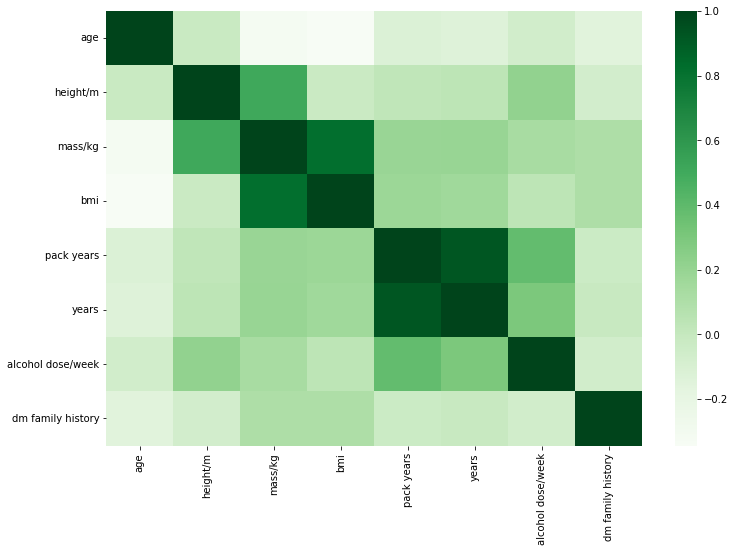

In [902]:
corr = df.corr(method="spearman")
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Greens")
plt.show()

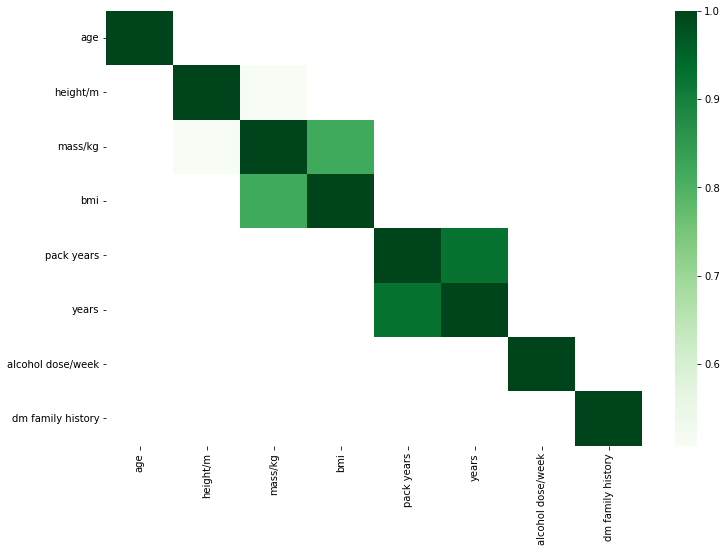

In [903]:
kot = corr[abs(corr) >= 0.5] 
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")
plt.show()

As expected bmi and weight are correlated. We could have expected that the number of pack per year is proportional to the number fo years smoked. Now if we look at the correlations above 0.5 we don't see other significant pairs.

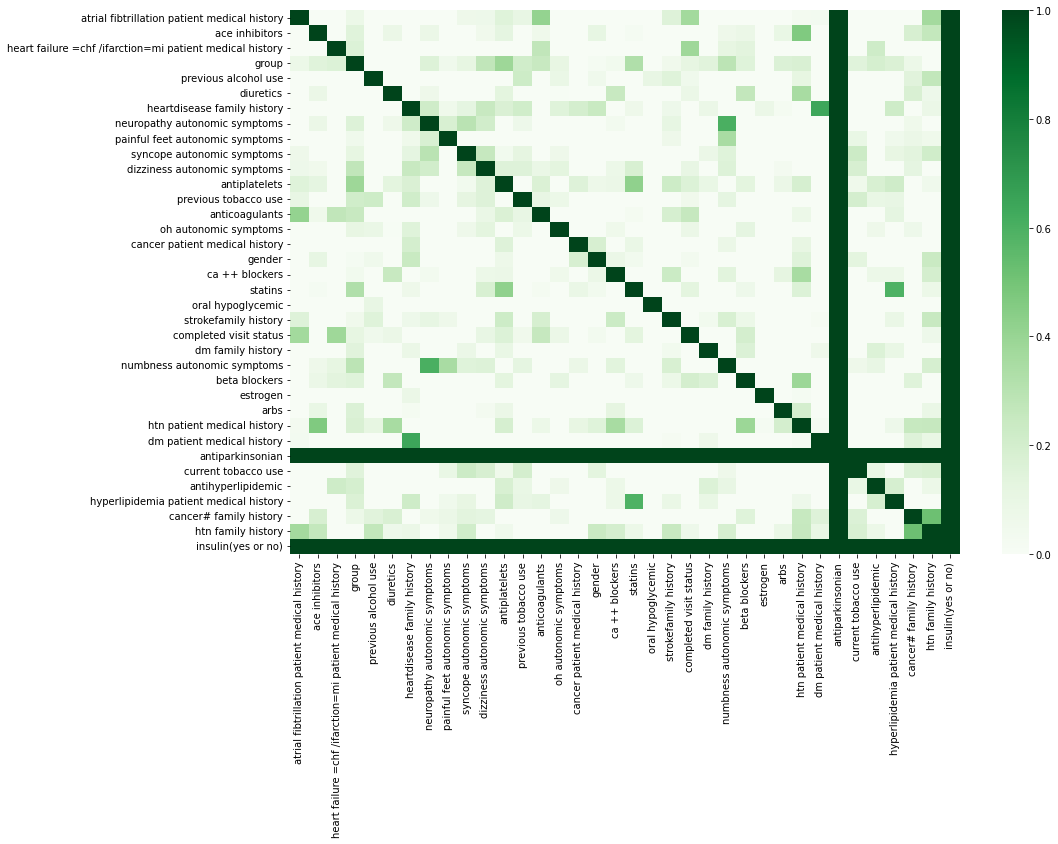

In [904]:
corr_cramer = prof.description_set["correlations"]['cramers']
plt.figure(figsize=(15,10))
sns.heatmap(corr_cramer, cmap="Greens")
plt.show()

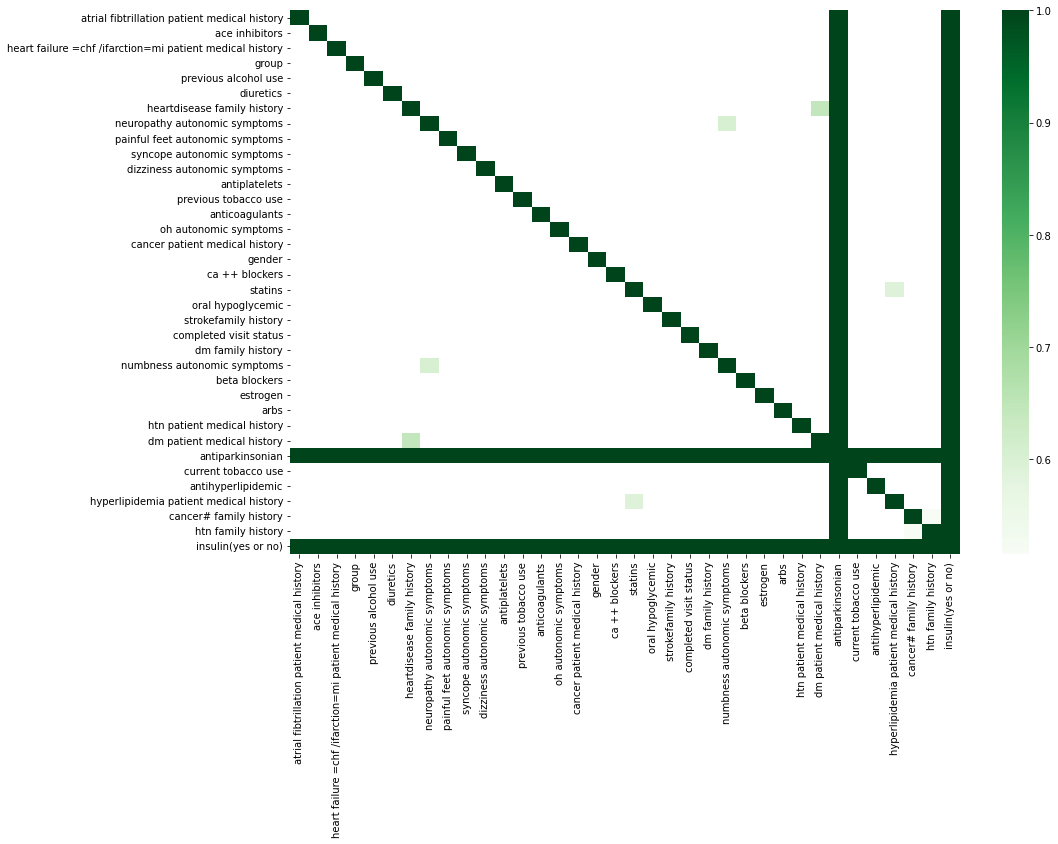

In [905]:
kot = corr_cramer[abs(corr_cramer) >= 0.5] 
plt.figure(figsize=(15,10))
sns.heatmap(kot, cmap="Greens")
plt.show()

We can observed some expected correlations between: 
- heat disease family history and dm patient medical history 
- hyperlipidemia patient medical history and statins
- numbness automatic symptoms and neuropathy automatic symptoms

steps:
- drop features with only missing value
- drop study measures
- drop cognitive tests
- drop bio measures
- consistency: unknwnown and yes/n.
- drop redundant features: hypertension, stroke, dm
- drop inconsistent patients
- change type of dm family history 
- drop features listing family members having a certain disease (redundant with count)
- drop ethnicity and race
- drop features having more than 1/3 of missing value


For the cleaning part let's save some information
- study measures
- bio measures
- cognitive test 
- redundant feature
- inconsistent patients
- family members
- irrelevant features 

In [906]:
study_related = set(study_measures + study_measures_additional)
redundant_features = drop_dm + drop_htn + stroke_drop + family_members
inconsistent_patients = list(inconsistent_patient_stroke) + list(inconsistent_patient_htn) + list(consent)
irrelevant_features =  ["ethnicity", "race"]

In [907]:
inconsistent_patients

['s0155',
 's0186',
 's0214',
 's0224',
 's0237',
 's0266',
 's0293',
 's0367',
 's0384',
 's0425',
 's0030',
 's0064',
 's0199',
 's0230',
 's0234',
 's0258',
 's0284',
 's0285',
 's0289',
 's0298',
 's0309',
 's0358',
 's0394',
 's0396',
 's0410',
 's0167',
 's0192',
 's0195',
 's0418']

In [908]:
stroke_dict = {"study_measures": study_related,
"bio_measures": bio_measures,
"cognitive_tests": cognitive_tests, 
"redundant_features": redundant_features,
"inconsistent_patients": inconsistent_patients,
"irrelevant_features": irrelevant_features}

In [909]:
import pickle
with open('../data_cleaning/stroke_dict.pkl', 'wb') as f:
    pickle.dump(stroke_dict, f)

In [920]:
df.shape

(143, 44)

In [919]:
#output = pd.read_csv("../data_cleaning/clean_data/stroke_clean_v1.csv")
#df.compare(output)